In [8]:
import mdtraj as md
import numpy as np
import plotly.graph_objs as go
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import concurrent.futures
from scipy.spatial import distance_matrix
from scipy.special import sph_harm
from tqdm import tqdm


def plot_atoms(coordinates, values, x, filename="", cmap='Viridis' ):
    """
    plots a set of coordinates and colors them according to corresponding list of values 
    """

    #Slice the coordinates and values to include only the first 'x' atoms
    coordinates = coordinates[:, :x]  # Keep the first 'x' columns
    values = values[:x]  # Keep the first 'x' values

    # Create a 3D scatter plot using plotly for interactive visualization
    scatter = go.Scatter3d(
        x=coordinates[0], 
        y=coordinates[1], 
        z=coordinates[2], 
        mode='markers',
        marker=dict(
            size=7,
            color=values,
            colorscale=cmap,  # Colormap
            colorbar=dict(
                title='Value',
                len=0.7,  # Reduce the length of the colorbar relative to the plot
                thickness=15,  # Make the colorbar thinner
            ),
            opacity=0.8
        )
    )

    #Define the layout for the plot
    layout = go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',  # Keeps the axes proportional (e.g., same scale for all axes)
        ),
        
        width=800,  # Adjust overall figure width
        height=600,  # Adjust overall figure height
        margin=dict(l=0, r=0, b=0, t=0),  # Reduce margins to allow for a larger plot area
    )

    #Show Figure
    fig = go.Figure(data=[scatter], layout=layout)

    #Save Figure
    if filename != "":
        fig.write_image(f"{filename}.svg")

    fig.show()


def plot_atoms_static(coordinates, values, x, filename="", cmap='viridis'):
    """
    Plots a set of coordinates and colors them according to corresponding list of values
    in a static Matplotlib plot.
    """

    # Slice the coordinates and values to include only the first 'x' atoms
    coordinates = coordinates[:, :x]  # Keep the first 'x' columns
    values = values[:x]  # Keep the first 'x' values

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colormap
    scatter = ax.scatter(
        coordinates[0], coordinates[1], coordinates[2], 
        c=values, cmap=cmap, s=80, marker='o', depthshade=False
    )

    # # Add a color bar with title and customization
    # colorbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=15)
    # colorbar.set_label(r'$Q_6 > 0.5$', fontsize=14)

    # Set labels and plot settings
    ax.set_xlabel("X", weight='bold')
    ax.set_ylabel("Y", weight='bold')
    ax.set_zlabel("Z", weight='bold')
    ax.set_box_aspect([1, 1, 1])  # Equal scaling for all axes

    # Adjust margins for a larger plot area
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Save the figure if a filename is provided
    if filename:
        plt.savefig(f"{filename}.svg", format='svg',dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


def plot_spherical_harmonic(l, m, filename="", res=100, show_axes=True, show_colorbar=True):
    """
    Plot the magnitude of the spherical harmonic Y_lm on a unit sphere with optional axes and color bar.
    
    Parameters:
    l (int): Degree of the spherical harmonic.
    m (int): Order of the spherical harmonic.
    filename (str): Name of the file to save the plot. If empty, no file is saved.
    res (int): Resolution of the sphere (number of theta and phi steps).
    show_axes (bool): If True, show the axes and labels.
    show_colorbar (bool): If True, show the color bar.
    """
    # Create a grid of theta and phi values
    theta = np.linspace(0, np.pi, res)  # Polar angle (0 to pi)
    phi = np.linspace(0, 2 * np.pi, res)  # Azimuthal angle (0 to 2*pi)
    theta, phi = np.meshgrid(theta, phi)

    # Calculate the spherical harmonic function
    Y_lm = sph_harm(m, l, phi, theta)

    # Get the real part for color mapping
    Y_lm_real = np.real(Y_lm)

    # Convert spherical coordinates to Cartesian coordinates on the unit sphere
    x_unit = np.sin(theta) * np.cos(phi)
    y_unit = np.sin(theta) * np.sin(phi)
    z_unit = np.cos(theta)

    # Plotting the spherical harmonic on the unit sphere
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize the colormap based on Y_lm_real
    norm = (Y_lm_real - Y_lm_real.min()) / (Y_lm_real.max() - Y_lm_real.min())

    # Plot the surface with color mapping to the magnitude of Y_lm and no edges
    surface = ax.plot_surface(
        x_unit, y_unit, z_unit, rstride=1, cstride=1,
        facecolors=plt.cm.seismic(norm), 
        edgecolor='none', alpha=0.9
    )

    if not show_axes:
        # Remove axes and grid lines
        ax.set_axis_off()
    else:
        # Set labels for the axes
        ax.set_xlabel('X', fontweight='bold')
        ax.set_ylabel('Y', fontweight='bold')
        ax.set_zlabel('Z', fontweight='bold')

    if show_colorbar:
        # Add a color bar to show the magnitude scale
        magnitude_map = plt.cm.ScalarMappable(cmap='seismic')
        magnitude_map.set_array(np.abs(Y_lm))
        fig.colorbar(magnitude_map, ax=ax, shrink=0.5, aspect=10, label="Magnitude")

    # Save Figure
    if filename != "":
        plt.savefig(f"{filename}", dpi=300)

    plt.show()


def load_coordinates(gro, xtc, frame_number):
    """
    Extracts the coordinates of the CA atoms from a given trajectory frame
    """

    #Load the specific frame using MDTraj
    traj = md.load(xtc, top=gro, frame=frame_number)

    #Select only CA atoms (alpha carbons)
    ca_atoms = traj.topology.select("name CA")

    #Create a new trajectory object containing only the CA atoms
    ca_traj = traj.atom_slice(ca_atoms)

    #Extract coordinates of CA atoms (from the first and only frame, so we use index 0)
    coordinates = ca_traj.xyz[0].T  # Transpose to separate x, y, z coordinates

    #Extract box sizes of current frame
    box_length = ca_traj.unitcell_lengths[0]

    return coordinates, box_length


def compute_neighbor_vectors(coords, box, adjacency_matrix):
    """
    Compute the neighbor vectors for each atom in the system considering periodic boundary conditions (PBC).
    
    Parameters:
        coords (np.ndarray): Array of shape (n_atoms, 3) containing the coordinates of the atoms.
        box (np.ndarray): Array of shape (3,) containing the box dimensions for PBC.
        adjacency_matrix (np.ndarray): Array of shape (n_atoms, n_atoms), where 1 indicates atoms are neighbors.
    
    Returns:
        list of np.ndarray: List where each element contains the bond vectors (n_neighbors, 3) for each atom.
    """
    #Compute pairwise displacement matrix
    n_atoms = coords.shape[0]
    
    #Calculate all pairwise displacements using broadcasting
    displacements = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    
    #Apply periodic boundary conditions
    displacements -= box * np.round(displacements / box)
    
    #Mask out non-neighbors using the adjacency matrix (neighbors indicated by 1)
    neighbor_vectors = [displacements[i][adjacency_matrix[i] == 1] for i in range(n_atoms)]
    
    return neighbor_vectors


def compute_q6(neighbor_vectors, l=6):
    """
    Compute the normalized q6 vectors for all atoms in the system using vectorization.
    
    Parameters:
        neighbor_vectors (list of np.ndarray): A list where each element contains the bond vectors 
                                               (n_neighbors, 3) for each atom.
        l (int): Degree of spherical harmonics (default is 6).
    
    Returns:
        np.ndarray: An array of normalized q6 vectors for all atoms, shape (n_atoms, 2l+1).
    """
    n_atoms = len(neighbor_vectors)
    q6_vectors = np.zeros((n_atoms, 2 * l + 1), dtype=complex)  # Store q6 vector for each atom
    
    #Loop over all atoms
    for i, neighbors in enumerate(neighbor_vectors):
        if neighbors.size == 0:
            continue  # Skip if no neighbors

        #Vectorized spherical coordinate calculation
        r = np.linalg.norm(neighbors, axis=1)
        theta = np.arccos(neighbors[:, 2] / r)
        phi = np.arctan2(neighbors[:, 1], neighbors[:, 0])
        
        #Compute all spherical harmonics at once
        m_values = np.arange(-l, l + 1)
        Y_lm = np.array([sph_harm(m, l, phi, theta) for m in m_values])  # Shape (2l+1, n_neighbors)
        
        #Sum the spherical harmonics for each atom and normalize
        q6_vectors[i, :] = np.sum(Y_lm, axis=1) 
        q6_vectors[i, :] /= np.sqrt(np.sum(np.abs(q6_vectors[i, :])**2))  # Normalize the q6 vector
    
    return q6_vectors


def compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, cutoff):
    """
    Compute the local Steinhardt Q6 parameter for all atoms in a vectorized manner.
    
    Parameters:
        q6_vectors (np.ndarray): Array of normalized q6 vectors for all atoms, shape (n_atoms, 2l+1).
        adjacency_matrix (np.ndarray): Adjacency matrix indicating neighbors (n_atoms, n_atoms).
        dist_matrix (np.ndarray): Pairwise distance matrix (n_atoms, n_atoms).
        cutoff (float): Distance cutoff for the neighbor interaction.
    
    Returns:
        np.ndarray: An array of local Q6 values for all atoms, shape (n_atoms,).
    """
    #Mask out distances larger than the cutoff
    neighbor_mask = (dist_matrix <= cutoff) & (adjacency_matrix == 1)
    
    #Compute the dot products of q6 vectors for all atoms
    q6_dot_products = np.real(np.einsum('ik,jk->ij', q6_vectors, np.conjugate(q6_vectors)))
    
    #Apply the neighbor mask to the dot products
    q6_weighted_dot_products = q6_dot_products * neighbor_mask
    
    #Compute the numerator (sum of weighted dot products) and denominator (number of neighbors)
    numerator = np.sum(q6_weighted_dot_products, axis=1)
    denominator = np.sum(neighbor_mask, axis=1)
    
    #Prevent division by zero
    denominator[denominator == 0] = 1
    
    #Compute the final local Q6 values
    local_q6_values = numerator / denominator #Normalized localq6 value
    # local_q6_values = numerator # Unnormallized localq6 value
    
    return local_q6_values


def pbc_distance_matrix(coords, box_length):
    """
    Compute the pairwise distance matrix with periodic boundary conditions.

    Parameters:
    coords: array_like
        The coordinates of the points (shape: [N, 3]).
    box_length: array_like
        The box lengths in each dimension (shape: [3] for x, y, z).
    
    Returns:
    dist_matrix: array_like
        Pairwise distance matrix with PBC applied (shape: [N, N]).
    """

    #Get number of atoms in the system
    num_atoms = len(coords)

    #Initialize the distance matrix
    dist_matrix = np.zeros((num_atoms, num_atoms))

    #Fill each element in the matrix
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            delta = coords[i] - coords[j]
            #Apply minimum image convention
            delta = delta - box_length * np.round(delta / box_length)
            dist = np.sqrt(np.sum(delta ** 2))
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # Symmetric matrix
    
    return dist_matrix


def compute_adjacency_matrix(coordinates, cutoff, atom_values, box, PBC=True):
    """
    Computes an adjacency matrix where the value is 1 for atom pairs within the cutoff distance, and 0 otherwise.

    Parameters:
        coordinates (np.ndarray): Array of shape (n_atoms, 3) containing the coordinates of the atoms.
        cutoff (float): Distance threshold for determining adjacency.

    Returns:
        np.ndarray: Adjacency matrix of shape (n_atoms, n_atoms), with 1 indicating atoms are within the cutoff distance.
    """
    
    #Transpose the coordinates
    coordinates = coordinates.T

    #Check if Periodic Boundary Conditions need to be taken into account
    if PBC:
        #Compute the periodic pairwise distance matrix
        dist_matrix = pbc_distance_matrix(coordinates, box)
    else:
        #Compute the pairwise distance matrix
        dist_matrix = distance_matrix(coordinates, coordinates)

    #Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
    adjacency_matrix = (dist_matrix <= cutoff).astype(int)

    #Set the diagonal to 0 (since an atom is not adjacent to itself)
    np.fill_diagonal(adjacency_matrix, 0)

    #Remove atoms that are not crystalline (lq6 < 1)
    crystal_filter = np.outer(atom_values, atom_values)
    final_matrix = adjacency_matrix * crystal_filter

    return final_matrix


def dfs(node, adj_matrix, visited, cluster):
    """
    Perform DFS to find all nodes connected to the given node.

    Parameters:
        node (int): The current node to start DFS from.
        adj_matrix (np.ndarray): The adjacency matrix representing the graph.
        visited (set): A set of nodes that have already been visited.
        cluster (list): The current cluster being formed.
    """
    visited.add(node)
    cluster.append(node)

    #Traverse all neighbors of the current node
    for neighbor, is_connected in enumerate(adj_matrix[node]):
        if is_connected == 1 and neighbor not in visited:
            dfs(neighbor, adj_matrix, visited, cluster)


def find_clusters(adj_matrix):
    """
    Find clusters in the graph using DFS.

    Parameters:
        adj_matrix (np.ndarray): The adjacency matrix representing the graph.
    
    Returns:
        list of list: A list of clusters, where each cluster is a list of nodes.
    """
    visited = set()
    clusters = []

    #Iterate through each node in the graph
    for node in range(len(adj_matrix)):
        if node not in visited:
            #If the node is not visited, start a new cluster
            cluster = []
            dfs(node, adj_matrix, visited, cluster)
            clusters.append(cluster)

    return clusters


def process_frame(topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff):
    """Processes a single frame and returns the largest cluster size."""

    #Extract the coordinates of CA atom for this frame
    coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

    #Get the periodic pairwise distances between atoms matrix
    dist_matrix = pbc_distance_matrix(coords.T, box)

    #Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
    adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

    #Set the diagonal to 0 (since an atom is not adjacent to itself)
    np.fill_diagonal(adjacency_matrix, 0)

    #Compute the neighbor vectors for each atom
    neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

    #Compute Q6 for each atom
    q6_vectors = compute_q6(neighbor_vectors)

    #Compute Local Q6 for each atom
    local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

    #Select only atoms for which lq6 is high enough
    values_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)

    #Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
    crystal_filter = np.outer(values_cutoff, values_cutoff)
    crystal_matrix = adjacency_matrix * crystal_filter

    #Find clusters within connected crystal atoms
    clusters = find_clusters(crystal_matrix)

    #Select largest cluster
    largest_cluster = max(clusters, key=len)

    return len(largest_cluster)


def calculate_crystal_sizes(topology_file, trajectory_file, min_frame, max_frame, stride, lq6_cutoff, d_cutoff, PBC=True, num_workers=None):
    """Tracks the size of the largest crystal for frames within a trajectory (parallelized)."""

    # Store results as tuples of (frame_number, cluster_size)
    results = []

    # Set up a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Prepare a list of tasks for each frame
        futures = {
            executor.submit(
                process_frame,
                topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff
            ): frame_number
            for frame_number in range(min_frame, max_frame, stride)
        }

        # Collect results as they are completed
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            frame_number = futures[future]  # Retrieve the frame number associated with this future
            cluster_size = future.result()  # Get the result (cluster size) for this frame
            results.append((frame_number, cluster_size))

    # Sort the results by frame number to ensure the correct order
    results_sorted = sorted(results, key=lambda x: x[0])

    # Extract the cluster sizes in the correct order
    cluster_size = np.array([result[1] for result in results_sorted])

    # Use the same name as input file for the output
    output_file = trajectory_file.replace('.xtc', '')

    # Save the crystal sizes as .npy file
    np.save(f'{output_file}_crystal_sizes', cluster_size)

    return cluster_size



# Crystal Systems

The following cells are used for the production of the results for the experiments with the crystal systems. We plot the size of the alpha, beta and gamma crystals over time for a trajectory of 100 ns for various temperatures. 

In [9]:
min_frame = 0
max_frame = 100000
stride = 500

lq6_cutoff = 0.5
d_cutoff = 0.6

temps = [275, 280, 285, 290, 295, 300]

crystal_sizes = []

for i in range(6):
    #Load the crystal sizes
    size = np.load(f'Trajectories/crystal/alpha_glycine_crystal_3_1_3_box_5.0_solv_minim_npteq{temps[i]}K_md_crystal_sizes.npy')
    crystal_sizes.append(size)

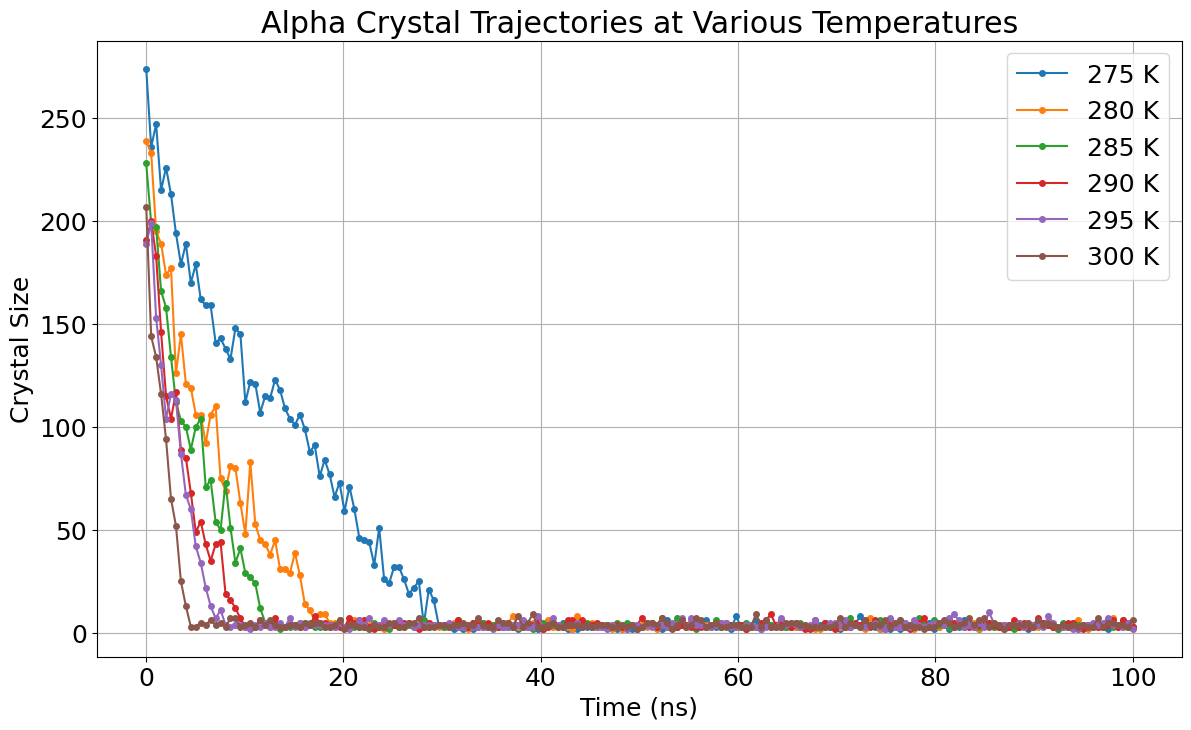

In [10]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 100, frames)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', markersize=4, label=f'{temps[i]} K')

plt.title('Alpha Crystal Trajectories at Various Temperatures')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/alpha_crystal_results.svg', dpi=300)
plt.show()

In [11]:
min_frame = 0
max_frame = 100000
stride = 500

lq6_cutoff = 0.5
d_cutoff = 0.6

temps = [275, 280, 285, 290, 295, 300]

crystal_sizes = []

for i in range(6):
    #Load the crystal sizes
    size = np.load(f'Trajectories/crystal/beta_glycine_crystal_3_3_3_box_5.0_solv_minim_npteq{temps[i]}K_md_crystal_sizes.npy')
    crystal_sizes.append(size)

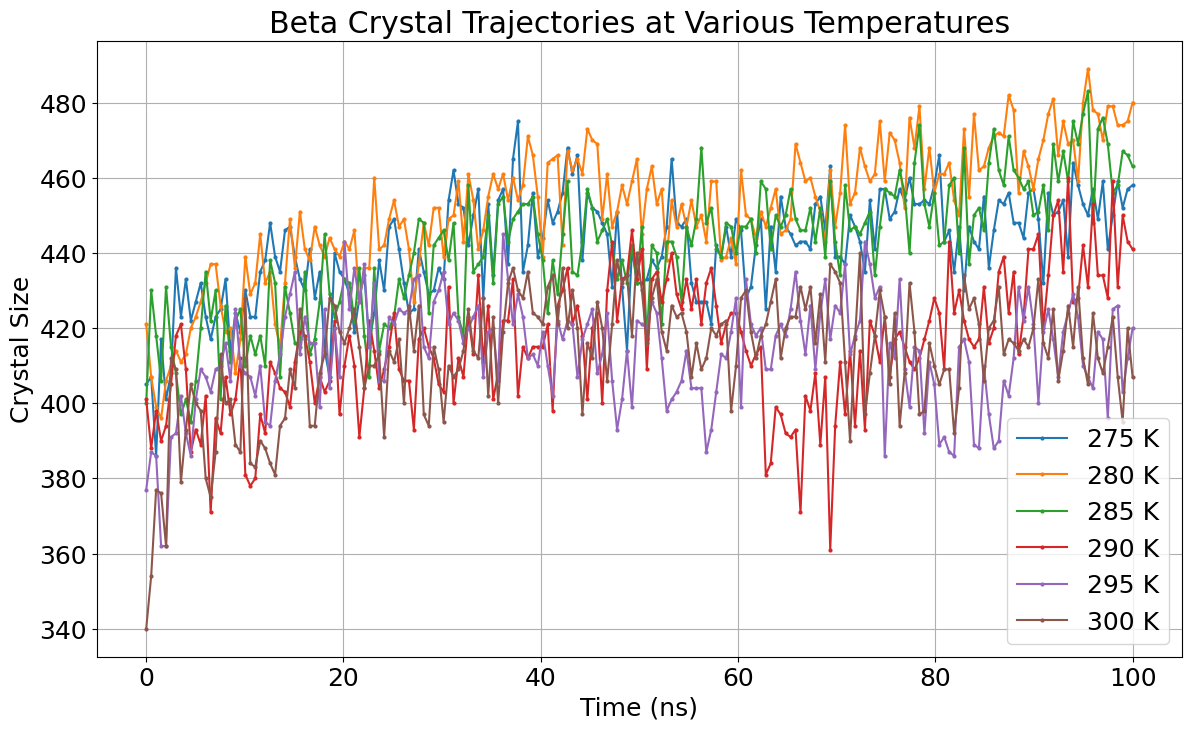

In [12]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 100, frames)
# Increase font sizes globally
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', markersize=2, label=f'{temps[i]} K')

plt.title( 'Beta Crystal Trajectories at Various Temperatures')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/beta_crystal_5.0_results.svg', dpi=300)
plt.show()

In [13]:
min_frame = 0
max_frame = 100000
stride = 500

lq6_cutoff = 0.5
d_cutoff = 0.6

temps = [275, 280, 285, 290, 295, 300]

crystal_sizes = []

for i in range(6):
    #Load the crystal sizes
    size = np.load(f'Trajectories/crystal/beta_glycine_crystal_3_3_3_box_6.0_solv_minim_npteq{temps[i]}K_md_crystal_sizes.npy')
    crystal_sizes.append(size)

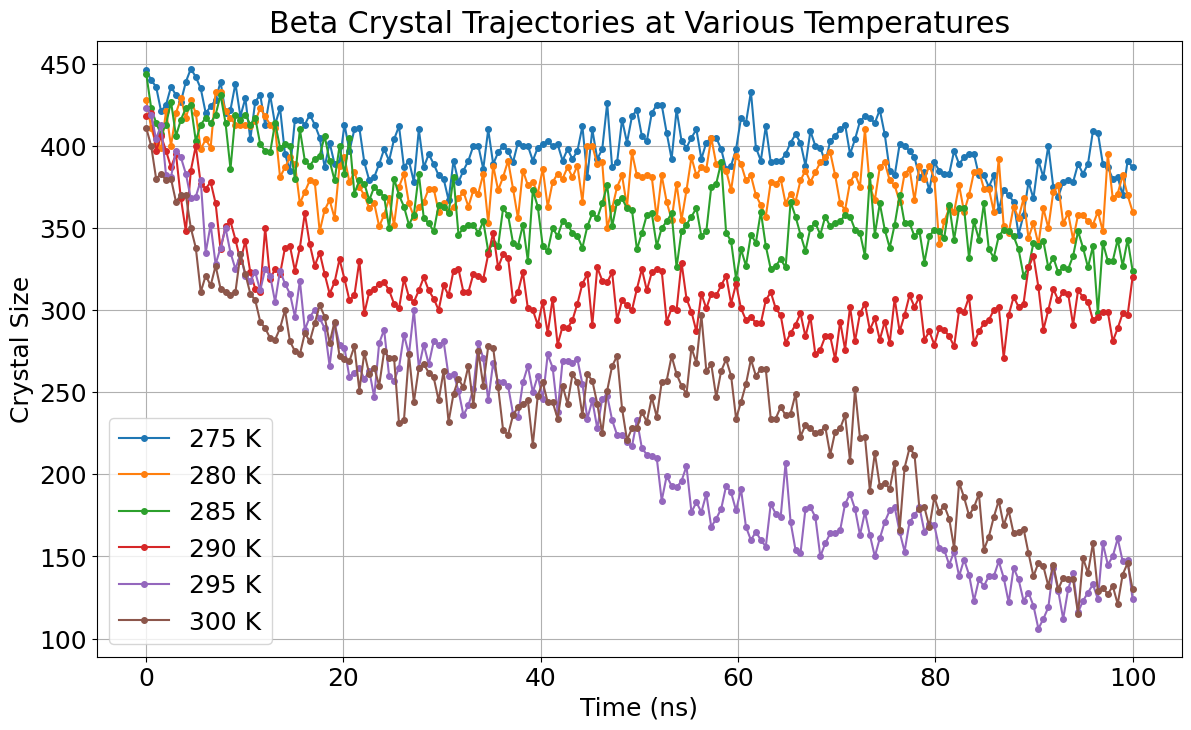

In [14]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 100, frames)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', markersize=4, label=f'{temps[i]} K')

plt.title( 'Beta Crystal Trajectories at Various Temperatures')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/beta_crystal_6.0_results.svg', dpi=300)
plt.show()

In [15]:
min_frame = 0
max_frame = 100000
stride = 500

lq6_cutoff = 0.5
d_cutoff = 0.6

temps = [275, 280, 285, 290, 295, 300]

crystal_sizes = []

for i in range(6):
    #Load the crystal sizes
    size = np.load(f'Trajectories/crystal/gamma_glycine_crystal_3_2_3_box_5.0_solv_minim_npteq{temps[i]}K_md_crystal_sizes.npy')
    crystal_sizes.append(size)

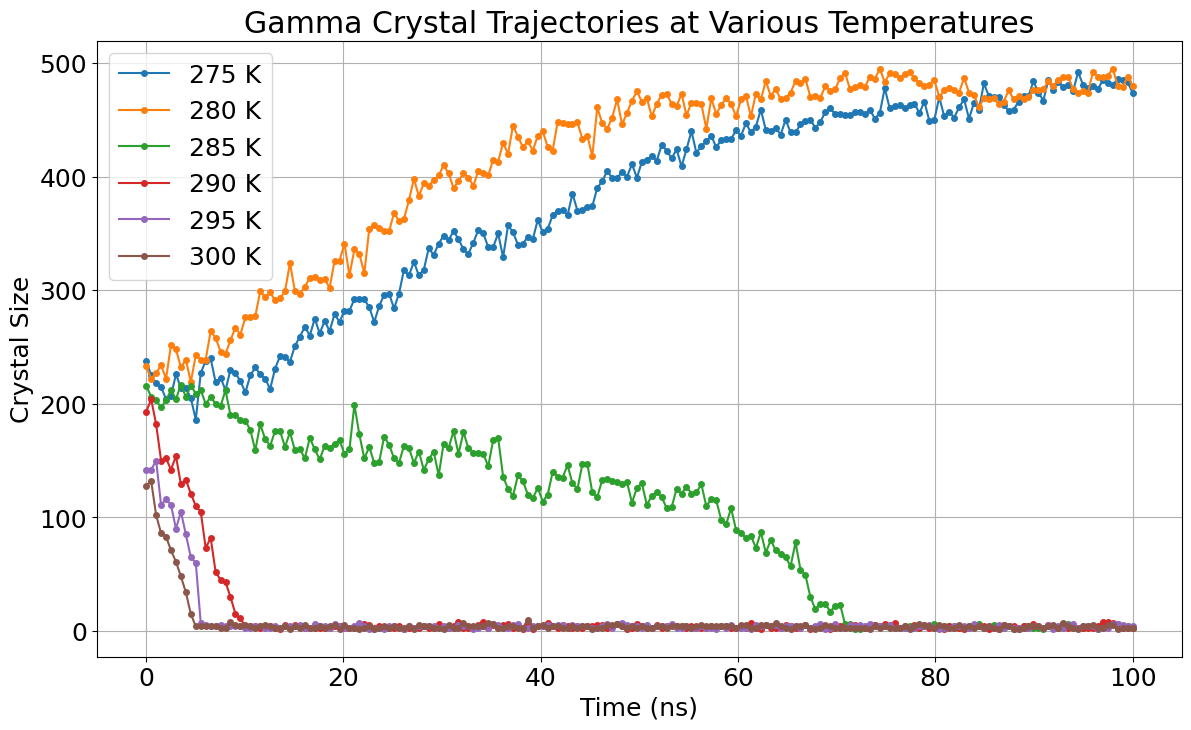

In [16]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 100, frames)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', markersize=4, label=f'{temps[i]} K')

plt.title( 'Gamma Crystal Trajectories at Various Temperatures')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/gamma_crystal_results.svg', dpi=300)
plt.show()

# Sphere Systems

The following cells are used for the production of the results for the experiments with the spherical systems. The first section plots crystal size of the gamma sphere with different nucleus radii for a 50ns simulation at 275K. The second section shows the crystal size for repeated runs of 500ns at 275K for the 1.7nm radius.

In [17]:
nuc_sizes = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
inserts = [554, 548, 530, 503, 471, 412, 342, 278]
crystal_sizes = []

for i in range(len(nuc_sizes)):

    #Load the trajecory
    
    file = f'Trajectories/sphere/gamma_glycine_crystal_3_2_3_box_5.0_{nuc_sizes[i]}nm_sphere_insert_{inserts[i]}_solv_minim_npteq275K_md_crystal_sizes.npy'  
    sizes = np.load(file)
    crystal_sizes.append(sizes)

In [18]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 50, frames)
# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', label=f'{nuc_sizes[i]} nm', markersize=4)

plt.title('Gamma Sphere Radius Trajectories at 275 K')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/sphere_radius_results.svg', dpi=300)
plt.show()

In [19]:

crystal_sizes = []

for i in range(1,11):

    #Load the trajecory
    
    file = f'Trajectories/1.7nm/gamma_glycine_crystal_3_2_3_box_5.0_1.7nm_sphere_insert_303_solv_minim_npteq275K_md_run{i}_short_crystal_sizes.npy'  
    sizes = np.load(file)
    crystal_sizes.append(sizes)

In [20]:
# Indices to exclude

exclude_indices = [5, 8, 9,7]
# Select remaining trajectories

remaining_sizes = [crystal_sizes[idx] for idx in range(len(crystal_sizes)) if idx not in exclude_indices]

# Extract frames 300 to 500 (Python indexing: 300-499)

frames_300_to_500 = [trajectory[400:500] for trajectory in remaining_sizes]
# Compute the mean size over all these observations

mean_size = np.mean([size for traj in frames_300_to_500 for size in traj])
mean_size

480.17

In [21]:
def calc_concentration(num_gly, num_sol):
    """Given number of glycine and water molecules calculates the concentration in mol/kg
    
    PARAMETERS:
    -----------
        num_gly: int
            number of glycine molecules in solution
        num_sol: int
            number of water molecules in solution
    
    RETURNS:
    --------
        conc_gly: float
            concentration of glycine in solution (mol/kg)
    """

    #Calculate mass of water in grams
    mass_sol = 18.015 * num_sol/1000 

    #Calculate concentration of glycine molecules
    conc_gly = num_gly/mass_sol

    return round(conc_gly,2)

num_gly = 558 - int(mean_size)
print(num_gly)

calc_concentration(num_gly, 2147)

78


2.02

In [22]:
frames = len(crystal_sizes[0])
time_ns = np.linspace(0, 500, frames)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(len(crystal_sizes)):
    # Plotting each crystal size in the same figure
    plt.plot(time_ns, crystal_sizes[i], marker='o', linestyle='-', markersize=2,label=f"Run {i}")

plt.title('1.7 nm Gamma Sphere Trajectories at 275 K')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()
plt.savefig('Figures/1.7nm_radius_results.svg', dpi=300)
plt.show()

# Ionized Sphere System

The following cells are used to plot the effect of ions on the growth of the gamma crystal.



In [23]:
no_ions_sizes = []

for i in range(1,11):

    #Load the trajecory
    
    file = f'Trajectories/ions/gamma_glycine_crystal_3_2_3_box_5.0_1.4nm_sphere_insert_412_solv_minim_npteq275K_md_run{i}_crystal_sizes.npy'  
    sizes = np.load(file)
    no_ions_sizes.append(sizes)

In [24]:
frames = len(no_ions_sizes[0])
time_ns = np.linspace(0, 50, frames)
# Increase font sizes globally
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(10):
    # Plotting each crystal size in the same figure
    plt.plot(no_ions_sizes[i], marker='o', linestyle='-', label=f'Crystal Size {i+1}', markersize=4)

plt.title('1.4 nm Gamma Sphere Trajectories at 275 K Without Ions ')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
# plt.legend()
plt.show()  # Show the figure after plotting all lines

In [25]:

ions_50_sizes = []

for i in range(1,11):

    #Load the trajecory
    
    file = f'Trajectories/ions/gamma_glycine_crystal_3_2_3_box_5.0_1.4nm_sphere_insert_412_solv_ions_50_minim_npteq275K_md_run{i}_crystal_sizes.npy'  
    sizes = np.load(file)
    ions_50_sizes.append(sizes)

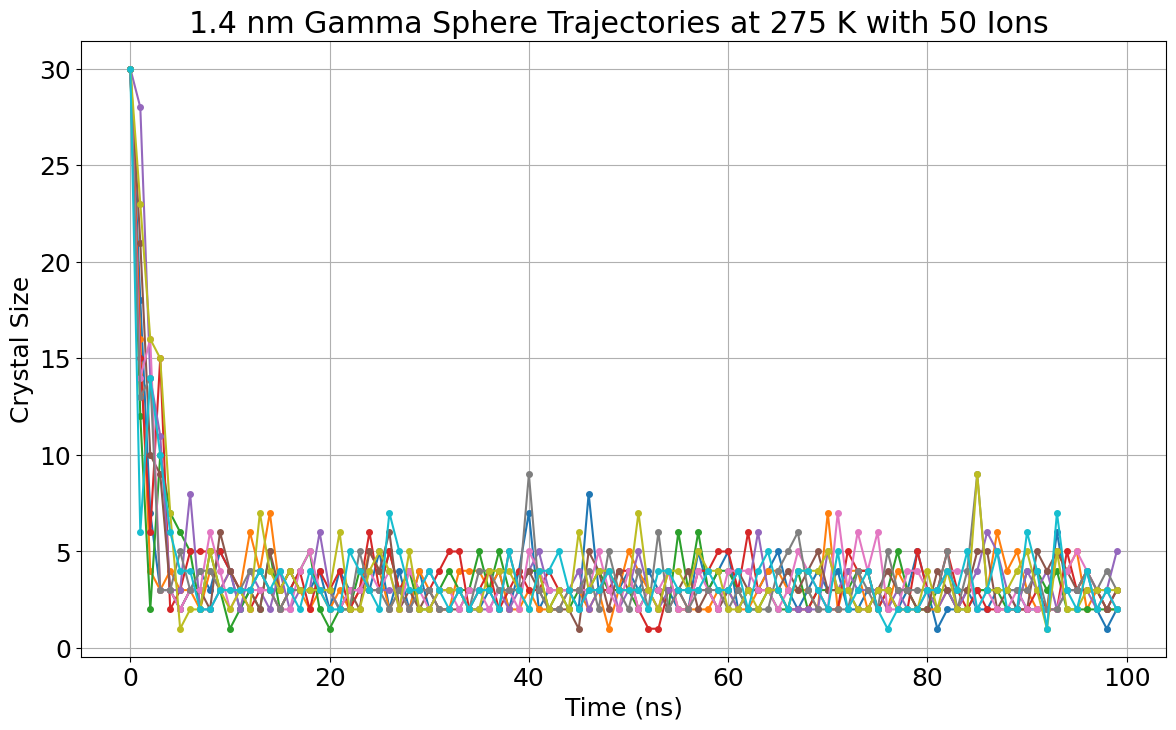

In [26]:
frames = len(ions_50_sizes[0])
time_ns = np.linspace(0, 50, frames)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(10):
    # Plotting each crystal size in the same figure
    plt.plot(ions_50_sizes[i], marker='o', linestyle='-', label=f'Crystal Size {i+1}', markersize=4)

plt.title('1.4 nm Gamma Sphere Trajectories at 275 K with 50 Ions ')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
# plt.legend()
plt.show()  # Show the figure after plotting all lines

In [27]:
ions_100_sizes = []

for i in range(1,11):

    #Load the trajecory
    
    file = f'Trajectories/ions/gamma_glycine_crystal_3_2_3_box_5.0_1.4nm_sphere_insert_412_solv_ions_100_minim_npteq275K_md_run{i}_crystal_sizes.npy'  
    sizes = np.load(file)
    ions_100_sizes.append(sizes)

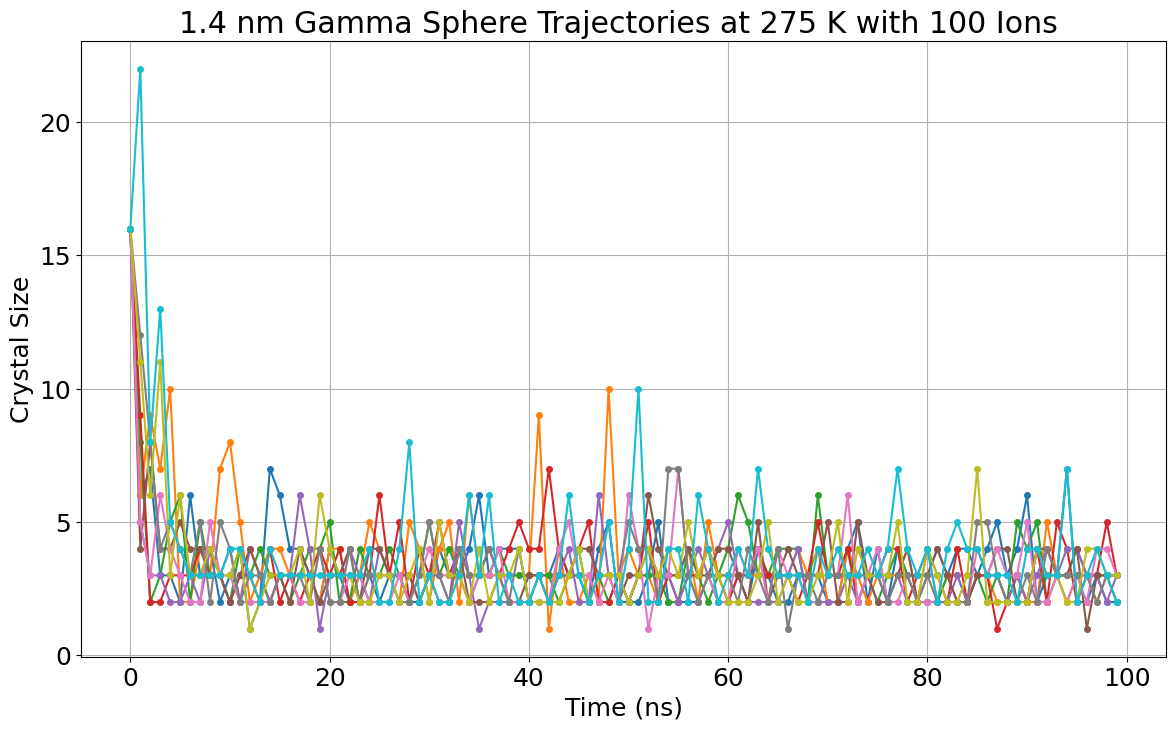

In [28]:
frames = len(ions_100_sizes[0])
time_ns = np.linspace(0, 50, frames)
# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 8))  # Create the figure once

for i in range(10):
    # Plotting each crystal size in the same figure
    plt.plot(ions_100_sizes[i], marker='o', linestyle='-', label=f'Crystal Size {i+1}', markersize=4)

plt.title('1.4 nm Gamma Sphere Trajectories at 275 K with 100 Ions ')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.grid(True)
# plt.legend()
plt.show()  # Show the figure after plotting all lines

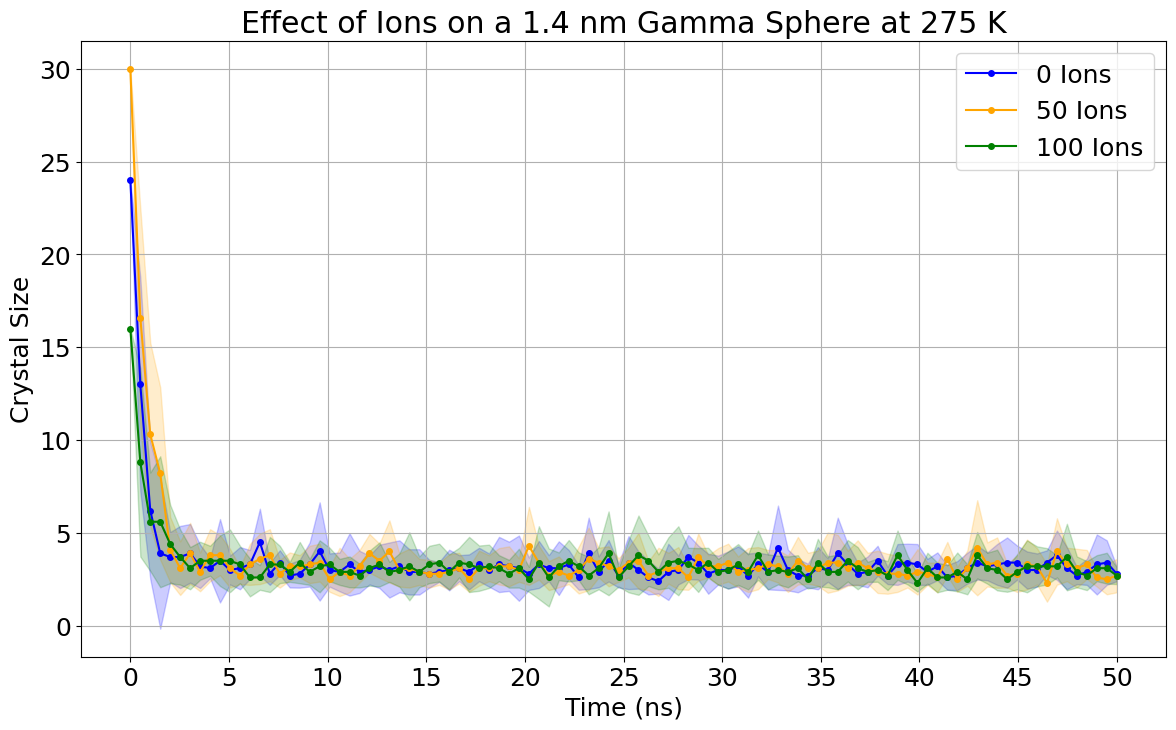

In [29]:
# Compute mean and standard deviation for each list at each frame
mean_no_ions = np.mean(no_ions_sizes, axis=0)
std_no_ions = np.std(no_ions_sizes, axis=0)

mean_ions_50 = np.mean(ions_50_sizes, axis=0)
std_ions_50 = np.std(ions_50_sizes, axis=0)

mean_ions_100 = np.mean(ions_100_sizes, axis=0)
std_ions_100 = np.std(ions_100_sizes, axis=0)

# Convert frame index to time in nanoseconds
frames = len(mean_no_ions)
time_ns = np.linspace(0, 50, frames)  # Assuming the simulation runs from 0 ns to 50 ns over 100 frames

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
# Plotting the means with standard deviations and markers
plt.figure(figsize=(14, 8))

# Plot for 0 ions
plt.plot(time_ns, mean_no_ions, marker='o', linestyle='-', label='0 Ions', color='blue', markersize=4)
plt.fill_between(time_ns, mean_no_ions - std_no_ions, mean_no_ions + std_no_ions, color='blue', alpha=0.2)

# Plot for 50 ions
plt.plot(time_ns, mean_ions_50, marker='o', linestyle='-', label='50 Ions', color='orange', markersize=4)
plt.fill_between(time_ns, mean_ions_50 - std_ions_50, mean_ions_50 + std_ions_50, color='orange', alpha=0.2)

# Plot for 100 ions
plt.plot(time_ns, mean_ions_100, marker='o', linestyle='-', label='100 Ions', color='green', markersize=4)
plt.fill_between(time_ns, mean_ions_100 - std_ions_100, mean_ions_100 + std_ions_100, color='green', alpha=0.2)

# Plot labels and grid
plt.title('Effect of Ions on a 1.4 nm Gamma Sphere at 275 K')
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.xticks(np.linspace(0, 50, 11))  # Set x-ticks from 0 ns to 50 ns at 5 ns intervals
plt.grid(True)
plt.legend()

plt.savefig('Figures/ions_effect.svg', dpi=300)

plt.show()

# Initial Conditions

The following cells are used to showcase the initial conditions that were used as input to the one way shooting algorithm of Transition Path Sampling. It combines run 3 (green) and run 8 (grey) of the 1.7nm trajectory samples. A gaussian bias is used for selecting shooting points from this initial path. This Gaussian is plotted as well.

In [30]:
crystal_sizes = []

for i in range(1,11):

    #Load the trajecory
    
    file = f'Trajectories/1.7nm/gamma_glycine_crystal_3_2_3_box_5.0_1.7nm_sphere_insert_303_solv_minim_npteq275K_md_run{i}_short_crystal_sizes.npy'  
    sizes = np.load(file)
    crystal_sizes.append(sizes)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

min_frame = 0
# Mirror the values of crystal_sizes[7]
mirrored_size_7 = crystal_sizes[7][::-1]

# Concatenate the mirrored crystal_sizes[7] with crystal_sizes[2]
concatenated_size = np.concatenate((mirrored_size_7, crystal_sizes[2]))

# Generate frame indices for the entire concatenated series
num_frames_7 = len(crystal_sizes[7])
num_frames_2 = len(crystal_sizes[2])
frames_7 = list(range(min_frame, min_frame + num_frames_7))  # Generate frame indices for mirrored run
frames_2 = list(range(min_frame + num_frames_7, min_frame + num_frames_7 + num_frames_2))  # Indices for original run

# Concatenate the frame ranges
concatenated_frames = np.concatenate((frames_7, frames_2))

# Ensure that frames and sizes have the same length
if len(concatenated_frames) > len(concatenated_size):
    concatenated_frames = concatenated_frames[:len(concatenated_size)]  # Trim frames if they are longer
elif len(concatenated_size) > len(concatenated_frames):
    concatenated_size = concatenated_size[:len(concatenated_frames)]  # Trim sizes if they are longer


# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
# Set figure size
plt.figure(figsize=(14, 8))

# Plot the first part (mirrored) in grey
plt.plot(concatenated_frames[:num_frames_7], concatenated_size[:num_frames_7], 
         marker='o', linestyle='-', markersize=3, color='grey', label='Inverted Run8')

# Plot the second part (original) in green
plt.plot(concatenated_frames[num_frames_7:], concatenated_size[num_frames_7:], 
         marker='o', linestyle='-', markersize=3, color='green', label='Run3')

# Add labels and title
plt.xlabel('Timestep (ns)')
plt.ylabel('Crystal Size')
plt.title(f"Nucleation Trajectory")
plt.grid(True)

# Save the plot
plt.savefig(f'Figures/initial_conditions.svg', dpi=300)

# Display the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


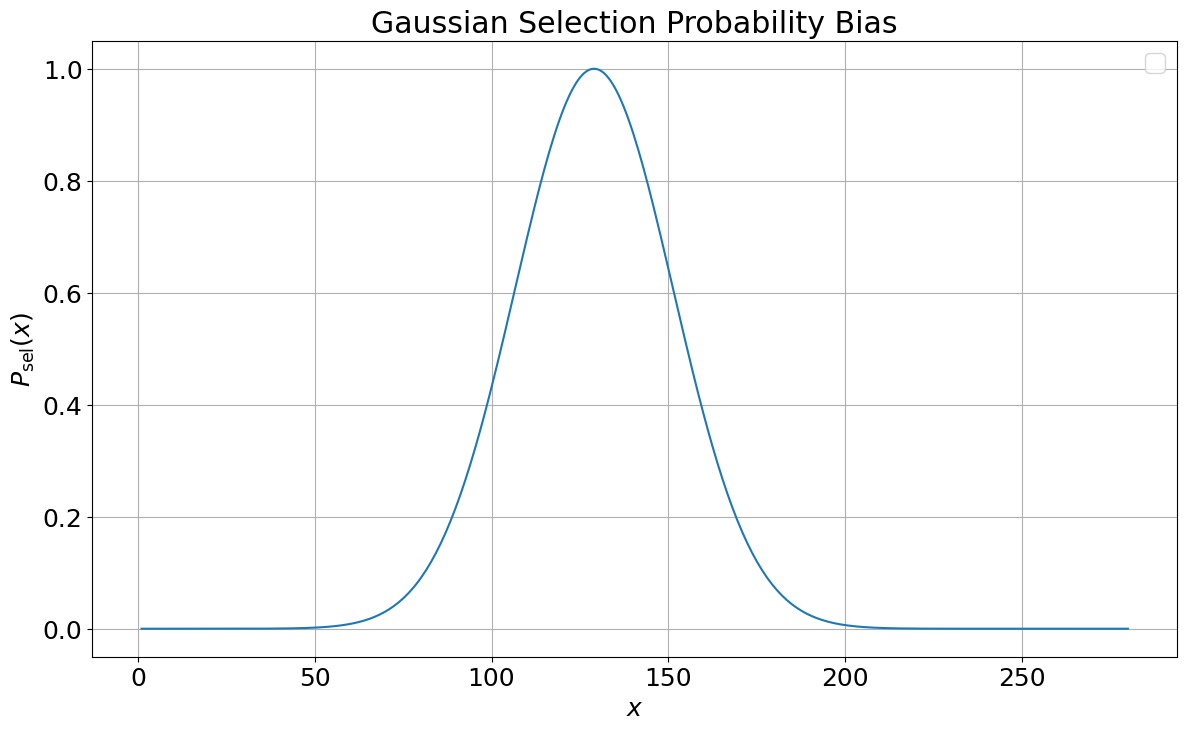

In [32]:
# Define parameters
alpha = 1/1000  # Width of Gaussian
l0 = 129     # Mean of Gaussian

# Define the function lambda(x), here we assume lambda(x) = x
def lambda_x(x):
    return x

# Define the function P_sel(x)
def P_sel(x, alpha, l0):
    return np.exp(-alpha * (lambda_x(x) - l0)**2)

# Generate x values
x_values = np.linspace(1, 280, 400)

# Calculate P_sel(x) values
P_values = P_sel(x_values, alpha, l0)

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14,8))
# Plotting the function
plt.plot(x_values, P_values)
plt.title('Gaussian Selection Probability Bias')
plt.xlabel(r'$x$')
plt.ylabel(r'$P_{\mathrm{sel}}(x)$')
plt.grid(True)
plt.legend()
plt.savefig('Figures/gaussian_bias.svg', dpi=300)
plt.show()

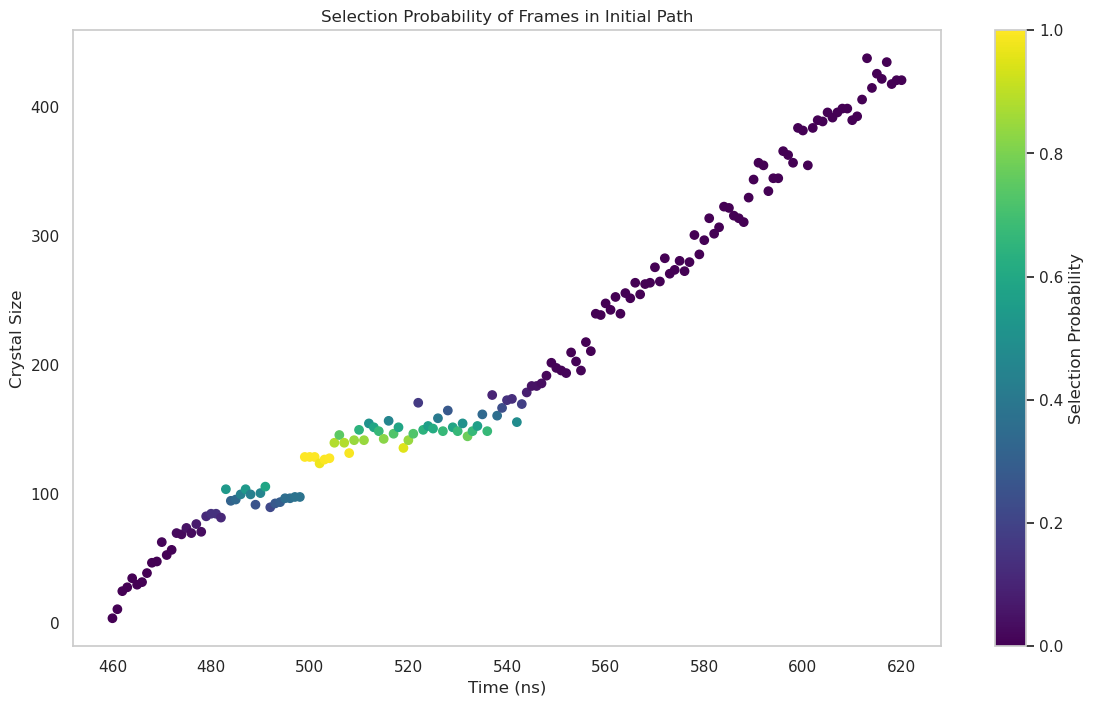

In [46]:
# Define the parameters for the Gaussian bias
alpha = 1 / 1000
l0 = 129

# Define the probability of selection function
def P_sel(x, alpha, l0):
    return np.exp(-alpha * (x - l0) ** 2)

# Calculate the selection probabilities for the crystal sizes
selection_probabilities = P_sel(np.array(concatenated_size), alpha, l0)

# Normalize the probabilities for coloring (between 0 and 1)
norm = plt.Normalize(vmin=min(selection_probabilities), vmax=max(selection_probabilities))

# Get a colormap (e.g., 'viridis' or any other)
cmap = cm.viridis

# Select the section from 460 ns to 620 ns
start_frame = 460  # starting frame (e.g., corresponding to 460 ns)
end_frame = 620    # ending frame (e.g., corresponding to 620 ns)

# Extract the section of data
section_indices = (concatenated_frames >= start_frame) & (concatenated_frames <= end_frame)
section_frames = concatenated_frames[section_indices]
section_sizes = concatenated_size[section_indices]
section_probabilities = selection_probabilities[section_indices]

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})
# Adjust figure size
plt.figure(figsize=(14, 8))

# Plot the data, coloring by selection probability
sc = plt.scatter(section_frames, section_sizes, c=section_probabilities, cmap=cmap, norm=norm) #plot selection
# sc = plt.scatter(concatenated_frames, concatenated_size, c=selection_probabilities, cmap=cmap, norm=norm) #plot complete paht

# Add a colorbar to show the mapping of colors to selection probabilities
plt.colorbar(sc, label='Selection Probability')

# Add labels and title to the plot
plt.xlabel('Time (ns)')
plt.ylabel('Crystal Size')
plt.title('Selection Probability of Frames in Initial Path')
plt.grid()
plt.savefig('Figures/initial_path_bias.svg', dpi=300)
# Show the plot
plt.show()

# Nucleation Barrier

The following cells produce schematic figures for nucleation barriers to illustrate the concepts of Classical Nucleation Theory. In addition it shows a schematic of a free energy landscape that illustrates one-step vs two-step nucleation.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 18})

# Constants
k_B = 1.380649e-23     # Boltzmann constant (J/K)
N_A = 6.02214076e23    # Avogadro's number (1/mol)
M = 0.018015           # Molar mass of water (kg/mol)
rho = 1000             # Density of water (kg/m^3)

# Parameters for water
gamma = 0.0728         # Surface tension of water at 25°C (J/m^2)

# Molecular volume of water (constant)
v_m = M / (N_A * rho)  # m^3/molecule

print(f"Calculated molecular volume (v_m): {v_m:.3e} m^3/molecule")

# Temperatures to consider (in Kelvin)
temperatures = [278.15, 288.15, 298.15, 308.15, 318.15]  # From 5°C to 45°C in 10°C increments

r_mult = [2.3, 2.1, 1.8, 1.6]

# Actual vapor pressure (increased to ensure S > 1)
P_actual = 10000  # Pa (increased value)

# Function to calculate saturation vapor pressure using the Clausius-Clapeyron equation
def saturation_vapor_pressure(T):
    # Constants for water
    L_v = 2.5e6        # Latent heat of vaporization (J/kg)
    R_v = 461.5        # Gas constant for water vapor (J/(kg·K))
    T_0 = 273.15       # Reference temperature (K)
    P_0 = 611          # Saturation vapor pressure at T_0 (Pa)

    # Clausius-Clapeyron equation
    P_sat = P_0 * np.exp((L_v / R_v) * (1 / T_0 - 1 / T))
    return P_sat

# Color map for plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))

# Create the plot
plt.figure(figsize=(14, 8))

# To store deltaG values for setting y-limits
deltaG_values = []

# Loop over temperatures
for idx, T in enumerate(temperatures):
    # Saturation vapor pressure at temperature T
    P_sat = saturation_vapor_pressure(T)
    
    # Supersaturation ratio
    S = P_actual / P_sat
    if S <= 1:
        print(f"\nTemperature: {T - 273.15:.1f} °C - Supersaturation less than or equal to 1, nucleation unlikely.")
        continue  # Skip this temperature if S <= 1

    # Bulk free energy change per unit volume
    deltaG_v = - (k_B * T * np.log(S)) / v_m  # J/m^3

    # Critical radius
    r_critical = - (2 * gamma) / deltaG_v

    # Barrier height
    deltaG_star = (16 * np.pi * gamma**3) / (3 * deltaG_v**2)
    deltaG_star_kJ_per_mol = deltaG_star * N_A / 1000  # Convert to kJ/mol

    print(f"\nTemperature: {T - 273.15:.1f} °C")
    print(f"Saturation vapor pressure (P_sat): {P_sat:.2f} Pa")
    print(f"Supersaturation ratio (S): {S:.3f}")
    print(f"Bulk free energy change per unit volume (ΔG_v): {deltaG_v:.3e} J/m^3")
    print(f"Critical radius (r*): {r_critical * 1e9:.2f} nm")
    print(f"Energy barrier (ΔG*): {deltaG_star_kJ_per_mol:.2e} kJ/mol")

    # Radius range (from near zero to a bit beyond critical radius)
    r_max = r_critical * r_mult[idx]
    r = np.linspace(1e-10, r_max, 500)

    # Calculate surface term and volume term
    surface_term = 4 * np.pi * r**2 * gamma
    volume_term = (4/3) * np.pi * r**3 * deltaG_v

    # Total Gibbs free energy change
    deltaG = surface_term + volume_term  # Units: J

    # Convert to kJ/mol
    deltaG_kJ_per_mol = deltaG * N_A / 1000
    surface_term_kJ_per_mol = surface_term * N_A / 1000
    volume_term_kJ_per_mol = volume_term * N_A / 1000

    # Store deltaG values for y-limits
    deltaG_values.extend(deltaG_kJ_per_mol)

    # Plotting
    plt.plot(r * 1e9, deltaG_kJ_per_mol, label=f'{T - 273.15:.1f} °C', color=colors[idx], linewidth=2)

    if idx == 3:
        plt.plot(r * 1e9, surface_term_kJ_per_mol, linestyle='--', color='red', linewidth=2, label="interface")
        plt.plot(r * 1e9, volume_term_kJ_per_mol, linestyle='--', color='blue', linewidth=2, label="volume")

        # Mark the critical radius and barrier height
        plt.axvline(r_critical * 1e9, color='grey', linestyle=':')
        plt.axhline(deltaG_star_kJ_per_mol, color='grey', linestyle=':')

# Set the x and y limits
plt.xlim(0, 3)  # Set x-axis range from 0 to 3 nm
# Set the x and y limits


# Adjust y-limits based on deltaG values
deltaG_values = np.array(deltaG_values)
deltaG_min = deltaG_values.min()
deltaG_max = deltaG_values.max()
y_margin = (deltaG_max - deltaG_min) * 0.1
plt.ylim(-200, deltaG_max + y_margin)

# Annotate the critical radius (r*)
plt.text(r_critical * 1e9 + 0.05, deltaG_star_kJ_per_mol -45, r'$r^*$', fontsize=14, color='grey', ha='left', va='center')

# Annotate the barrier height (ΔG*)
plt.text(r_critical * 1e9 -0.2, deltaG_star_kJ_per_mol + 10, r'$\Delta G^*$', fontsize=14, color='grey', ha='center', va='bottom')


# Labels and legend
plt.xlabel('Radius, $r$ / nm')
# plt.xlabel('$r$', fontsize=24) # for presentation

plt.ylabel('Gibbs energy, $\Delta G(r)$ / kJ·mol$^{-1}$')
# plt.ylabel('$\Delta G$', fontsize=24) # for presentation

plt.legend(title='Temperature', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/nucleation_barrier.svg", dpi=300)
plt.show()


Calculated molecular volume (v_m): 2.991e-29 m^3/molecule

Temperature: 5.0 °C
Saturation vapor pressure (P_sat): 872.70 Pa
Supersaturation ratio (S): 11.459
Bulk free energy change per unit volume (ΔG_v): -3.131e+08 J/m^3
Critical radius (r*): 0.47 nm
Energy barrier (ΔG*): 3.97e+01 kJ/mol

Temperature: 15.0 °C
Saturation vapor pressure (P_sat): 1715.53 Pa
Supersaturation ratio (S): 5.829
Bulk free energy change per unit volume (ΔG_v): -2.344e+08 J/m^3
Critical radius (r*): 0.62 nm
Energy barrier (ΔG*): 7.08e+01 kJ/mol

Temperature: 25.0 °C
Saturation vapor pressure (P_sat): 3222.85 Pa
Supersaturation ratio (S): 3.103
Bulk free energy change per unit volume (ΔG_v): -1.558e+08 J/m^3
Critical radius (r*): 0.93 nm
Energy barrier (ΔG*): 1.60e+02 kJ/mol

Temperature: 35.0 °C
Saturation vapor pressure (P_sat): 5811.76 Pa
Supersaturation ratio (S): 1.721
Bulk free energy change per unit volume (ΔG_v): -7.718e+07 J/m^3
Critical radius (r*): 1.89 nm
Energy barrier (ΔG*): 6.54e+02 kJ/mol

Temper

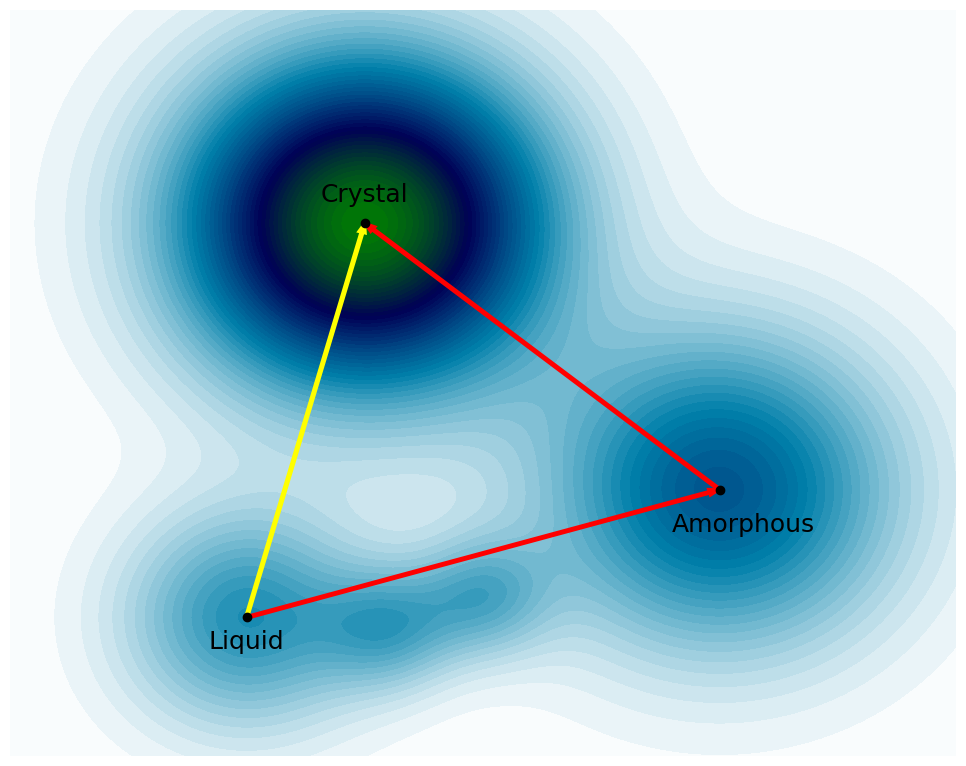

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the grid for the reaction coordinates
x = np.linspace(-4, 4, 500)
y = np.linspace(-3, 4, 500)
X, Y = np.meshgrid(x, y)

# Parameters for minima and barriers
# Positions of minima
x_A, y_A = -2.0, -1.7
x_B, y_B = 2, -0.5
x_C, y_C = -1, 2

# Energy levels (depths of minima)
E_A = -1.2    # Reference energy level for liquid phase
E_B = -1.8    # Metastable intermediate phase
E_C = -4.0    # Stable crystal phase

# Energy function
def energy_landscape(X, Y):
    # Wells (minima)
    E = E_A * np.exp(-((X - x_A)**2 + (Y - y_A)**2) / (2 * 0.70**2))
    E += E_B * np.exp(-((X - x_B)**2 + (Y - y_B)**2) / (2 * 1.0**2))
    E += E_C * np.exp(-((X - x_C)**2 + (Y - y_C)**2) / (2 * 1.0**2))

    # Additional features (optional)
    E += -0.8 * np.exp(-((X - 0)**2 + (Y - -1.5)**2) / (2 * 0.4**2))
    E += -0.8 * np.exp(-((X - -0.8)**2 + (Y - -1.8)**2) / (2 * 0.4**2))
    
    return E

# Calculate the energy landscape
E = energy_landscape(X, Y)

# Plotting
plt.figure(figsize=(10, 8))

# Use contourf to plot the energy landscape
contour = plt.contourf(X, Y, E, levels=50, cmap='ocean')

# Mark minima positions with black markers
plt.plot(x_A, y_A, 'o', color='black', markersize=6)
plt.plot(x_B, y_B, 'o', color='black', markersize=6)
plt.plot(x_C, y_C, 'o', color='black', markersize=6)

# Annotate minima with larger font size
plt.text(x_A, y_A - 0.3, 'Liquid', ha='center', color='black', fontsize=18)
plt.text(x_B+ 0.2, y_B - 0.4, 'Amorphous', ha='center', color='black', fontsize=18)
plt.text(x_C, y_C + 0.2, 'Crystal', ha='center', color='black', fontsize=18)

# Draw pathways with more vibrant colors and higher linewidth
# Two-step pathway: A -> B -> C
plt.arrow(x_A, y_A, x_B - x_A, y_B - y_A, width=0.02, color='red', linewidth=2, length_includes_head=True)
plt.arrow(x_B, y_B, x_C - x_B, y_C - y_B, width=0.02, color='red', linewidth=2, length_includes_head=True)

# Single-step pathway: A -> C
plt.arrow(x_A, y_A, x_C - x_A, y_C - y_A, width=0.02, color='yellow', linewidth=2, length_includes_head=True)

# Remove axes ticks and labels for schematic representation
plt.xticks([])
plt.yticks([])
plt.axis('off')  # Optionally remove the entire axis frame

# Adjust layout and save with higher DPI
plt.tight_layout()
plt.savefig("Figures/two-step_for_presentation.svg", dpi=600)
plt.show()


# Spherical Harmonics

The following cells are used to create figures that explain how spherical harmonics are leveraged to calculate the degree of crystallinity for a molecular system.

In [36]:

l = 6
m = 0

plot_spherical_harmonic(l, m, filename=f'Figures/Y{l}_{m}.png', res=100, show_axes=False, show_colorbar=False)

In [37]:
#Load the trajecory
topology_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K_md.xtc'  # or .trr, etc.

#Load specific frame for trajectory
frame_number = 0

#Extract the coordinates of CA atom for this frame
atom_coords, box = load_coordinates(topology_file, trajectory_file, frame_number)
atom_coords = atom_coords.T

# Select a center atom by index
center_index = 158  # Replace with desired atom index
center_point = atom_coords[center_index]

# Define the square size (e.g., 4.0 for a 4x4x4 region)
square_size = 1.5

# Select atoms within the square centered on the chosen atom
x_min, x_max = center_point[0] - square_size / 2, center_point[0] + square_size / 2
y_min, y_max = center_point[1] - square_size / 2, center_point[1] + square_size / 2
z_min, z_max = center_point[2] - square_size / 2, center_point[2] + square_size / 2

# Filter atoms within the specified boundaries
selected_atoms = atom_coords[
    (atom_coords[:, 0] >= x_min) & (atom_coords[:, 0] <= x_max) &
    (atom_coords[:, 1] >= y_min) & (atom_coords[:, 1] <= y_max) &
    (atom_coords[:, 2] >= z_min) & (atom_coords[:, 2] <= z_max)
]

# Create the scatter plot for atoms
atom_trace = go.Scatter3d(
    x=selected_atoms[:, 0],
    y=selected_atoms[:, 1],
    z=selected_atoms[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Selected Atoms'
)

# Mark the center atom
center_trace = go.Scatter3d(
    x=[center_point[0]],
    y=[center_point[1]],
    z=[center_point[2]],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Center Atom'
)

# Draw a sphere around the center atom
sphere_radius = 0.6  # Set sphere radius
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + center_point[0]
y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + center_point[1]
z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center_point[2]

# Create the sphere mesh
sphere_trace = go.Surface(
    x=x, y=y, z=z,
    opacity=0.3,
    surfacecolor=np.zeros_like(x),
    colorscale=[[0, 'green'], [1, 'green']],
    showscale=False,
    name='Sphere'
)

# Create the figure
fig = go.Figure(data=[atom_trace, center_trace, sphere_trace])

# Set the axis labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Show the plot
fig.show()


In [38]:
#Load the trajecory
topology_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K_md.xtc'  # or .trr, etc.

#Load specific frame for trajectory
frame_number = 500

#Extract the coordinates of CA atom for this frame
atom_coords, box = load_coordinates(topology_file, trajectory_file, frame_number)
atom_coords = atom_coords.T

# Select a center atom by index
center_index = 158  # Replace with desired atom index 
center_point = atom_coords[center_index]

# Define the square size
square_size = 1.5

# Define the boundaries and filter atoms within the square centered on the chosen atom
x_min, x_max = center_point[0] - square_size / 2, center_point[0] + square_size / 2
y_min, y_max = center_point[1] - square_size / 2, center_point[1] + square_size / 2
z_min, z_max = center_point[2] - square_size / 2, center_point[2] + square_size / 2

selected_atoms = atom_coords[
    (atom_coords[:, 0] >= x_min) & (atom_coords[:, 0] <= x_max) &
    (atom_coords[:, 1] >= y_min) & (atom_coords[:, 1] <= y_max) &
    (atom_coords[:, 2] >= z_min) & (atom_coords[:, 2] <= z_max)
]

# Create the figure with larger size and without axes, grid, or ticks
fig = plt.figure(figsize=(10, 10))  # Increased figure size
ax = fig.add_subplot(111, projection='3d')

# Plot selected atoms
ax.scatter(selected_atoms[:, 0], selected_atoms[:, 1], selected_atoms[:, 2], color='royalblue', s=50, label='Selected Atoms')
ax.scatter(center_point[0], center_point[1], center_point[2], color='crimson', s=100, label='Center Atom')

# Draw a sphere around the center atom
sphere_radius = 0.6  # Set sphere radius
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + center_point[0]
y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + center_point[1]
z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center_point[2]
ax.plot_wireframe(x, y, z, color="seagreen", alpha=0.3)

# Set tight axis limits around the center atom to zoom in and reduce white space
margin = -0.2  # Adjust this to control the "zoom" level
ax.set_xlim(center_point[0] - square_size / 2 - margin, center_point[0] + square_size / 2 + margin)
ax.set_ylim(center_point[1] - square_size / 2 - margin, center_point[1] + square_size / 2 + margin)
ax.set_zlim(center_point[2] - square_size / 2 - margin, center_point[2] + square_size / 2 + margin)

# Enhance aesthetics by removing axis details and gridlines
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.axis("off")  # Remove axes

plt.savefig("Figures/coordination_sphere_liquid.png", dpi=300, bbox_inches='tight', pad_inches=0)# Show the plot
plt.show()


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Load the trajecory
topology_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K_md.xtc'  # or .trr, etc.

#Load specific frame for trajectory
frame_number = 500

#Extract the coordinates of CA atom for this frame
atom_coords, box = load_coordinates(topology_file, trajectory_file, frame_number)
atom_coords = atom_coords.T

# Select a center atom by index
center_index = 56  # Replace with the desired atom index
center_point = atom_coords[center_index]

# Define the square size and filter atoms within the square centered on the chosen atom
square_size = 1.5
x_min, x_max = center_point[0] - square_size / 2, center_point[0] + square_size / 2
y_min, y_max = center_point[1] - square_size / 2, center_point[1] + square_size / 2
z_min, z_max = center_point[2] - square_size / 2, center_point[2] + square_size / 2

selected_atoms = atom_coords[
    (atom_coords[:, 0] >= x_min) & (atom_coords[:, 0] <= x_max) &
    (atom_coords[:, 1] >= y_min) & (atom_coords[:, 1] <= y_max) &
    (atom_coords[:, 2] >= z_min) & (atom_coords[:, 2] <= z_max)
]

# Select one neighbor to illustrate r_ij, theta_ij, and phi_ij
neighbor_point = selected_atoms[1]
r_vec = neighbor_point - center_point
r_ij = np.linalg.norm(r_vec)
theta_ij = np.arccos(r_vec[2] / r_ij)  # Polar angle
phi_ij = np.arctan2(r_vec[1], r_vec[0])  # Azimuthal angle

# Project the vector r_vec onto the horizontal (xy) plane
projection_xy = np.array([neighbor_point[0], neighbor_point[1], center_point[2]])

# Create the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot selected atoms
ax.scatter(selected_atoms[:, 0], selected_atoms[:, 1], selected_atoms[:, 2], color='royalblue', s=50, label='Selected Atoms')
ax.scatter(center_point[0], center_point[1], center_point[2], color='crimson', s=100, label='Center Atom')

# Draw the r_ij vector
ax.quiver(center_point[0], center_point[1], center_point[2], r_vec[0], r_vec[1], r_vec[2], color='black', linewidth=2)
ax.text(neighbor_point[0]+0.08, neighbor_point[1], neighbor_point[2], "$r_{ij}$", color="black", fontsize=18)

# Draw the projection of r_vec onto the xy-plane as a red dotted line from the center to projection_xy
ax.plot(
    [center_point[0], projection_xy[0]],
    [center_point[1], projection_xy[1]],
    [center_point[2], projection_xy[2]],
    'r--', linewidth=2, label="Projection on xy-plane"
)

# Draw a vertical red dotted line from projection_xy to the actual endpoint of r_vec
ax.plot(
    [projection_xy[0], neighbor_point[0]],
    [projection_xy[1], neighbor_point[1]],
    [projection_xy[2], neighbor_point[2]],
    'r--', linewidth=2
)

# Reference axes
axis_length = 1.0
ax.quiver(center_point[0], center_point[1], center_point[2], axis_length, 0, 0, color="grey", alpha=0.5)
ax.quiver(center_point[0], center_point[1], center_point[2], 0, axis_length, 0, color="grey", alpha=0.5)
ax.quiver(center_point[0], center_point[1], center_point[2], 0, 0, axis_length, color="grey", alpha=0.5)
ax.text(center_point[0] + axis_length, center_point[1], center_point[2], "$x$", color="grey")
ax.text(center_point[0], center_point[1] + axis_length, center_point[2], "$y$", color="grey")
ax.text(center_point[0], center_point[1], center_point[2] + axis_length, "$z$", color="grey")

# Sphere around the center atom
sphere_radius = 0.6  # Set sphere radius
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + center_point[0]
y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + center_point[1]
z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center_point[2]
ax.plot_wireframe(x, y, z, color="seagreen", alpha=0.3)

# Theta arc (in rz-plane, from z-axis to r_vec direction)
theta_arc_radius = r_ij / 3
theta_arc_points = np.linspace(0, theta_ij, 50)

# Calculate the arc coordinates by projecting onto the rz-plane in the direction of r_vec
theta_arc_x = center_point[0] + theta_arc_radius * np.sin(theta_arc_points) * (r_vec[0] / np.sqrt(r_vec[0]**2 + r_vec[1]**2))
theta_arc_y = center_point[1] + theta_arc_radius * np.sin(theta_arc_points) * (r_vec[1] / np.sqrt(r_vec[0]**2 + r_vec[1]**2))
theta_arc_z = center_point[2] + theta_arc_radius * np.cos(theta_arc_points)

# Draw the theta arc
ax.plot(theta_arc_x, theta_arc_y, theta_arc_z, color="blue", linewidth=2)
ax.text(theta_arc_x[0] + 0.02, theta_arc_y[0], theta_arc_z[0], "$\\theta_{ij}$", color="blue", fontsize=18)

# Phi arc (in xy-plane)
phi_arc_radius = r_ij / 3
phi_arc_theta = np.linspace(0, phi_ij, 50)
phi_arc_x = center_point[0] + phi_arc_radius * np.cos(phi_arc_theta)
phi_arc_y = center_point[1] + phi_arc_radius * np.sin(phi_arc_theta)
phi_arc_z = np.full_like(phi_arc_theta, center_point[2])

# Draw the phi arc
ax.plot(phi_arc_x, phi_arc_y, phi_arc_z, color="green", linewidth=2)
ax.text(phi_arc_x[0], phi_arc_y[0], phi_arc_z[0], "$\\phi_{ij}$", color="green", fontsize=18)

# Set the axis limits around the center atom to zoom in
margin = -0.15
ax.set_xlim(center_point[0] - square_size / 2 - margin, center_point[0] + square_size / 2 + margin)
ax.set_ylim(center_point[1] - square_size / 2 - margin, center_point[1] + square_size / 2 + margin)
ax.set_zlim(center_point[2] - square_size / 2 - margin, center_point[2] + square_size / 2 + margin)

# Remove the grid and axes for a clean look
ax.axis("off")

plt.savefig("Figures/coordination_sphere_angles.svg", dpi=300, bbox_inches='tight', pad_inches=0)# Show the plot

plt.show()


# Transition Path Sampling

The following cells are used to illustrate the iterations of the one-way shooting algorithm of Transition Path Sampling.

In [40]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Grid size and state boundary settings
grid_size_x, grid_size_y = 5000, 1000
liquid_state_x, liquid_state_width = 5, 505
crystal_state_x, crystal_state_width = 4995, 10

# Parameters for random walk generation
start_x, start_y = liquid_state_x + liquid_state_width, grid_size_y // 2
max_steps = 100000

initial_paths = []
trials = []
shooting_points = []

# Define the biased random walk function with strict forward/backward behavior
def strict_biased_random_walk(start_x, start_y, direction, max_steps, state_boundaries):
    x, y = start_x, start_y
    path = [(x, y)]
    for _ in range(max_steps):
        dx = 1 if direction == "forward" else -1
        dy = np.random.choice([-1, 1])
        x += dx
        y = np.clip(y + dy, 0, grid_size_y - 1)
        path.append((x, y))
        if state_boundaries[0] <= x < state_boundaries[1]:
            break
    return path

# Initial random walk path
initial_path = strict_biased_random_walk(start_x, start_y, "forward", max_steps,
                                         (crystal_state_x, crystal_state_x + crystal_state_width))
initial_paths.append(initial_path)

# Loop through the shooting processes
for cycle in range(3):
    # Recalculate path_length, middle_index, and range_width for the current path
    path_length = len(initial_paths[-1])
    middle_index = path_length // 2
    range_width = path_length // 4  # Adjust as needed
    
    # Select a random shooting point along the current path
    shooting_index = random.randint(
        max(0, middle_index - range_width),
        min(path_length - 1, middle_index + range_width)
    )
    shooting_x, shooting_y = initial_paths[-1][shooting_index]
    
    if cycle % 2 == 0:
        # Forward shooting move
        new_path = strict_biased_random_walk(shooting_x, shooting_y, "forward", max_steps,
                                             (crystal_state_x, crystal_state_x + crystal_state_width))
        # Exclude the shooting point from the new path to avoid duplication
        concatenated_path = initial_paths[-1][:shooting_index + 1] + new_path[1:]
    else:
        # Backward shooting move
        new_path = strict_biased_random_walk(shooting_x, shooting_y, "backward", max_steps,
                                             (liquid_state_x, liquid_state_x + liquid_state_width))
        # Reverse the backward path to have increasing x-values
        new_path = new_path[::-1]
        # Exclude the shooting point from the new path to avoid duplication
        concatenated_path = new_path[:-1] + initial_paths[-1][shooting_index:]
    
    # Append the shooting point and trial
    shooting_points.append([shooting_x, shooting_y])
    trials.append(new_path)
    # Update the initial path
    initial_paths.append(concatenated_path)

# Chocolate Tempering

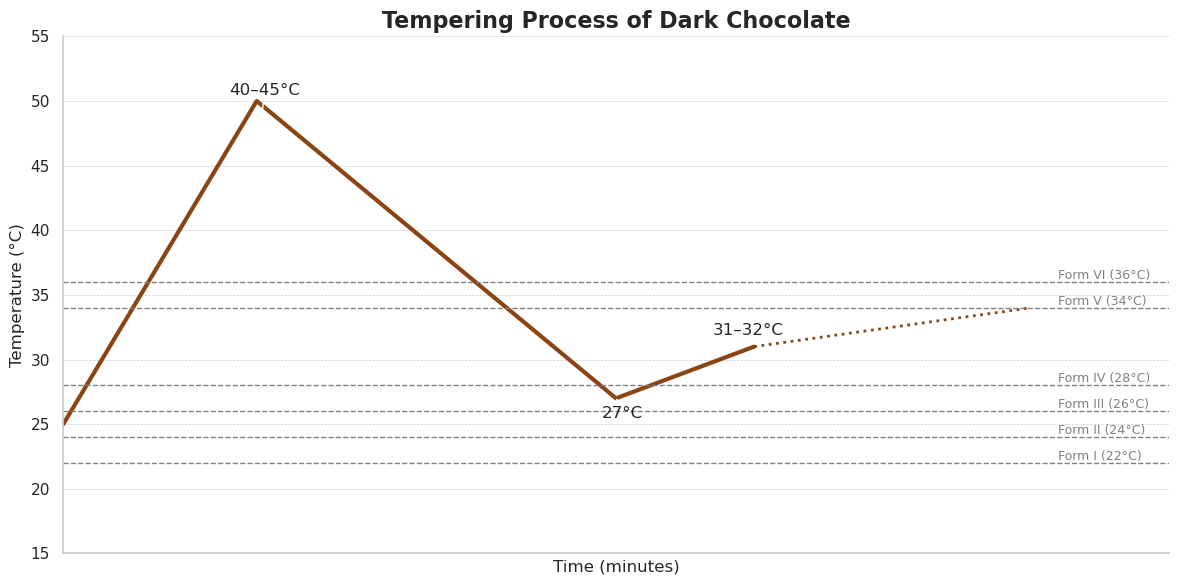

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})


# Set the style
sns.set(style='whitegrid')

# Updated cocoa butter polymorph melting temperatures (in °C)
phases = {
    'Form I': 22,
    'Form II': 24,
    'Form III': 26,
    'Form IV': 28,
    'Form V': 34,  # Desired stable form
    'Form VI': 36
}

# Tempering process data
time = [0, 7, 20, 25]
temperature = [25, 50, 27, 31]

plt.figure(figsize=(12, 6))

# Plot the tempering process
plt.plot(time, temperature, color='saddlebrown', linewidth=3, label='Tempering Process')

# Add the diagonal brown dotted line from (25, 31.5) to (35, 34.5)
plt.plot([25, 35], [31, 34], color='saddlebrown', linestyle=':', linewidth=2)

# Adjust label offset for phase label

# Plot phase stability lines and labels
for form, temp in phases.items():
    plt.axhline(y=temp, color='gray', linestyle='--', linewidth=1)
    plt.text(35 + 1, temp, f'{form} ({temp}°C)', va='bottom', ha='left', fontsize=9, color='gray')

# Add annotations based on Callebaut's guidelines


# Annotation for melting phase
plt.annotate('40–45°C',
             xy=(7, 45), xytext=(6, 50.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

# Annotation for cooling phase
plt.annotate('27°C',
             xy=(20, 27), xytext=(19.5, 25.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

# Annotation for reheating phase
plt.annotate('31–32°C',
             xy=(25, 31.5), xytext=(23.5, 31.9),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)


# Labels and title
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Tempering Process of Dark Chocolate', fontsize=16, fontweight='bold')

# X and Y limits
plt.xlim(0, 40)  # Increased limit to accommodate annotations and diagonal line
plt.ylim(15, 55)

# Remove x-ticks and x-axis label
# plt.xlabel('')
plt.xticks([])

# Customize y-ticks
plt.yticks(np.arange(15, 56, 5))

# Remove top and right spines
sns.despine()

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust plot margins to fit annotations
plt.subplots_adjust(right=0.85)

# Tight layout
plt.tight_layout()

plt.savefig("Figures/Chocolate_stability.svg",dpi=300)

# Show the plot
plt.show()


# Liquid, Droplet and Crystal Sizes



In [42]:
crystal_sizes = np.load("Trajectories/TPS/TPS_MC1_cont2_decor_2_crystal_sizes.npy")
droplet_sizes = np.load("Trajectories/TPS/TPS_MC1_cont2_decor_2_droplet_sizes.npy")
liquid_sizes  =  558 - (crystal_sizes + droplet_sizes)

In [43]:
crystal_sizes[50:150].mean()

101.68

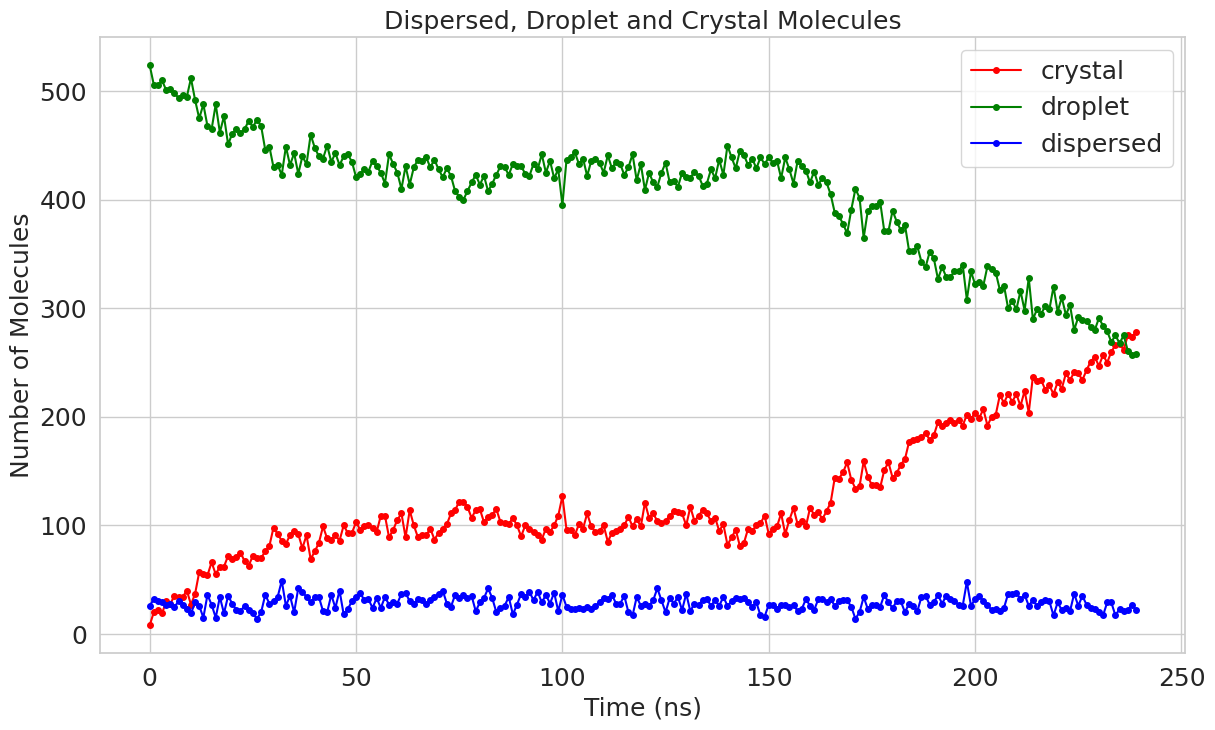

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))  # Create the figure

# Plot the data
plt.plot(crystal_sizes, marker='o', linestyle='-', markersize=4, label="crystal", color='red')
plt.plot(droplet_sizes, marker='o', linestyle='-', markersize=4, label="droplet", color='green')
plt.plot(liquid_sizes, marker='o', linestyle='-', markersize=4, label="dispersed", color='blue')

# Add title and labels with specified font sizes
plt.title('Dispersed, Droplet and Crystal Molecules', fontsize=18)
plt.xlabel('Time (ns)', fontsize=18)
plt.ylabel('Number of Molecules', fontsize=18)

# Customize tick font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Add grid
plt.grid(True)

# Add legend with specific font size
plt.legend(fontsize=18)

# Save the figure
plt.savefig('Figures/droplet_crystal_plot_decor_8.svg', dpi=300)

# Display the figure
plt.show()
